## Imports & Configuration

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --- CONFIGURATION ---
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    # VGG19 Mean values (BGR order): [123.68, 116.779, 103.939]
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
    OUTPUT_DIR = 'output/'

# Create output directory if it doesn't exist
if not os.path.exists(CONFIG.OUTPUT_DIR):
    os.makedirs(CONFIG.OUTPUT_DIR)

%matplotlib inline
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


## Helper functions (Image Processing)

In [2]:
def load_and_process_image(path):
    """Loads an image, resizes it, and normalizes it for VGG19."""
    img = Image.open(path)
    img = img.resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT))
    img = np.array(img).astype('float32')
    
    # Add batch dimension: (1, H, W, 3)
    img = np.expand_dims(img, axis=0)
    
    # Subtract mean (VGG preprocessing)
    img = img - CONFIG.MEANS
    return img

def save_image(path, image):
    """Un-normalizes the image and saves it."""
    # Add mean back (Broadcasting 4D + 4D is safe)
    image = image + CONFIG.MEANS
    
    # Clip to valid pixel range [0, 255]
    image = np.clip(image, 0, 255).astype('uint8')
    
    # Remove batch dimension just before saving
    if image.ndim == 4:
        image = image[0]
    
    # Save
    img = Image.fromarray(image)
    img.save(path)

def generate_noise_image(content_image, noise_ratio=CONFIG.NOISE_RATIO):
    """Creates a noisy image to start the training."""
    noise_image = np.random.uniform(
        -20, 20, 
        (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)
    ).astype('float32')
    
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

def imshow(image, title=None):
    """Display helper."""
    # 1. Add means back first (keep 4D structure)
    image = image + CONFIG.MEANS
    
    # 2. Clip values
    image = np.clip(image, 0, 255).astype('uint8')
    
    # 3. Remove batch dimension ONLY now, right before plotting
    if image.ndim == 4:
        image = image[0]
        
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

## The Model (VGG19 Feature Extractor)

In [3]:
def get_vgg_model():
    """
    Creates a VGG19 model that outputs specific content and style layer activations.
    """
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    # Defined Layers for Style and Content
    content_layer = 'block4_conv2'
    style_layers = [
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        'block4_conv1', 
        'block5_conv1'
    ]
    
    # Get the output tensors
    outputs = [vgg.get_layer(content_layer).output] + \
              [vgg.get_layer(name).output for name in style_layers]
    
    model = Model(inputs=vgg.input, outputs=outputs)
    return model

# Load the model once
vgg_model = get_vgg_model()
print("VGG19 Model Loaded successfully.")

VGG19 Model Loaded successfully.


## Cost Functions

- how we calculate the loss


In [4]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost (Mean Squared Error).
    """
    return tf.reduce_mean(tf.square(content_output - generated_output))

def gram_matrix(input_tensor):
    """
    Computes the Gram matrix for style correlation.
    """
    # Reshape to (batch, channels, height * width)
    result = tf.linalg.einsum('bijc->bijc', input_tensor)
    input_shape = tf.shape(input_tensor)
    B, H, W, C = input_shape[0], input_shape[1], input_shape[2], input_shape[3]
    
    # Reshape to (B, H*W, C)
    feats = tf.reshape(input_tensor, (B, H*W, C))
    
    # Compute Gram Matrix: G = F^T * F
    # Result shape: (B, C, C)
    gram = tf.matmul(feats, feats, transpose_a=True)
    
    return gram

def compute_layer_style_cost(style_output, generated_output):
    """
    Computes style cost for a single layer.
    """
    H, W, C = style_output.get_shape().as_list()[1:]
    
    S = gram_matrix(style_output)
    G = gram_matrix(generated_output)
    
    # Normalization factor
    size = H * W * C
    factor = 4.0 * (size ** 2) # Note: In some implementations, normalization varies. 
                               # Standard is 4 * (C^2) * ((H*W)^2), which is equivalent.
    
    cost = tf.reduce_sum(tf.square(S - G)) / (4.0 * (C**2) * ((H*W)**2))
    return cost

def compute_total_cost(model_outputs, content_target, style_targets, alpha=10, beta=40):
    """
    Combines content and style costs.
    """
    # model_outputs = [content_out, style_out1, style_out2, ...]
    generated_content = model_outputs[0]
    generated_styles = model_outputs[1:]
    
    # 1. Content Cost
    J_content = compute_content_cost(content_target, generated_content)
    
    # 2. Style Cost
    J_style = 0
    # Weights for each style layer (usually equal)
    weight_per_layer = 1.0 / len(style_targets)
    
    for i in range(len(generated_styles)):
        J_style_layer = compute_layer_style_cost(style_targets[i], generated_styles[i])
        J_style += weight_per_layer * J_style_layer
        
    # 3. Total Cost
    J_total = alpha * J_content + beta * J_style
    return J_total, J_content, J_style

## Training Loop

- this core logic uses GradientTape

In [25]:
@tf.function
def train_step(image, content_target, style_targets, alpha, beta, optimizer):
    with tf.GradientTape() as tape:
        # Forward pass
        outputs = vgg_model(image)
        
        # Calculate loss
        loss, c_loss, s_loss = compute_total_cost(outputs, content_target, style_targets, alpha, beta)
        
    # Calculate gradients
    grads = tape.gradient(loss, image)
    
    # Apply gradients
    optimizer.apply_gradients([(grads, image)])
    
    # Clip to keep pixel values valid (-123 to 150 range roughly)
    image.assign(tf.clip_by_value(image, -125.0, 125.0))
    
    return loss, c_loss, s_loss

def run_style_transfer(content_path, style_path, iterations=1000, alpha=10, beta=40, lr=0.6):
    # 1. Load Images
    print("Loading images...")
    content_image = load_and_process_image(content_path)
    style_image = load_and_process_image(style_path)
    
    # 2. Compute Targets (Run once)
    print("Computing targets...")
    content_targets = vgg_model(content_image)[0] # First output is content
    style_targets = vgg_model(style_image)[1:]    # Rest are style
    
    # 3. Initialize Generated Image
    generated_image = tf.Variable(generate_noise_image(content_image), dtype=tf.float32)
    
    # 4. Optimizer
    optimizer = Adam(learning_rate=lr)
    
    # 5. Training Loop
    print(f"Starting training for {iterations} iterations...")
    for i in range(iterations):
        loss, c_loss, s_loss = train_step(generated_image, content_targets, style_targets, alpha, beta, optimizer)
        
        if i % 50 == 0:
            print(f"Iter {i}: Total {loss:.2f} | Content {c_loss:.2f} | Style {s_loss:.2f}")
            save_image(f"{CONFIG.OUTPUT_DIR}/iter_{i}.jpg", generated_image.numpy())
            
    # Save Final
    final_path = f"{CONFIG.OUTPUT_DIR}/final_generated.jpg"
    save_image(final_path, generated_image.numpy())
    print(f"Done! Final image saved to {final_path}")
    
    return generated_image.numpy()

## Execution

- this will create my art...

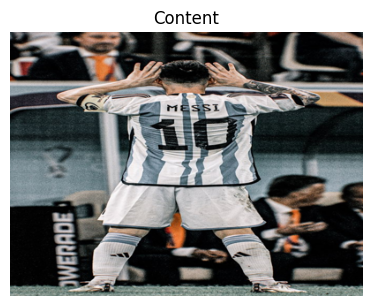

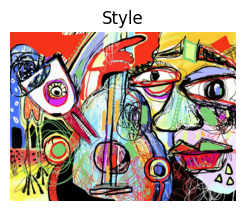

Loading images...
Computing targets...
Starting training for 350 iterations...
Iter 0: Total 5674706665472.00 | Content 290522.31 | Style 113494073344.00
Iter 50: Total 1243957690368.00 | Content 843786.19 | Style 24878985216.00
Iter 100: Total 360961867776.00 | Content 1089042.50 | Style 7219019776.00
Iter 150: Total 186969325568.00 | Content 1152652.00 | Style 3739155712.00
Iter 200: Total 124275253248.00 | Content 1188025.00 | Style 2485267456.00
Iter 250: Total 91533434880.00 | Content 1215529.50 | Style 1830425600.00
Iter 300: Total 71462363136.00 | Content 1238341.38 | Style 1428999552.00
Done! Final image saved to output//final_generated.jpg


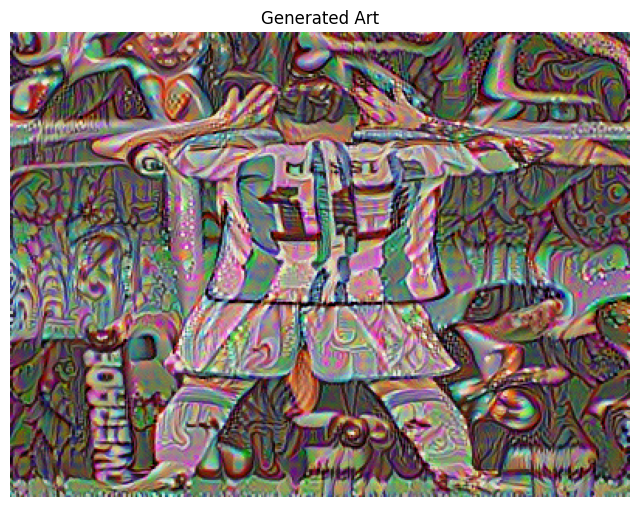

In [26]:
# Define your file paths here
CONTENT_PATH = "images\messi2arg.jpg"       # Make sure this file exists
STYLE_PATH = "images\cubeism2.webp"   # Make sure this file exists

# Verify files exist
if not os.path.exists(CONTENT_PATH):
    print(f"Error: Content image not found at {CONTENT_PATH}")
elif not os.path.exists(STYLE_PATH):
    print(f"Error: Style image not found at {STYLE_PATH}")
else:
    # Display inputs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(load_and_process_image(CONTENT_PATH), "Content")
    plt.subplot(1, 2, 2)
    imshow(load_and_process_image(STYLE_PATH), "Style")
    
    # Run!
    # Note: You can adjust alpha (content weight) and beta (style weight)
    final_img = run_style_transfer(CONTENT_PATH, STYLE_PATH, iterations=350, alpha=10, beta=50)
    
    # Show Result
    plt.figure(figsize=(8, 8))
    imshow(final_img, "Generated Art")

### **Some results**:

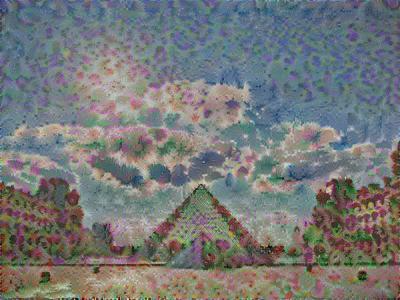

---

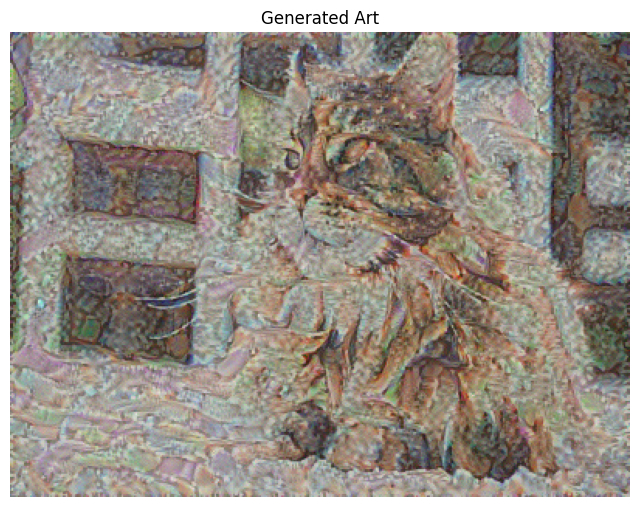

---

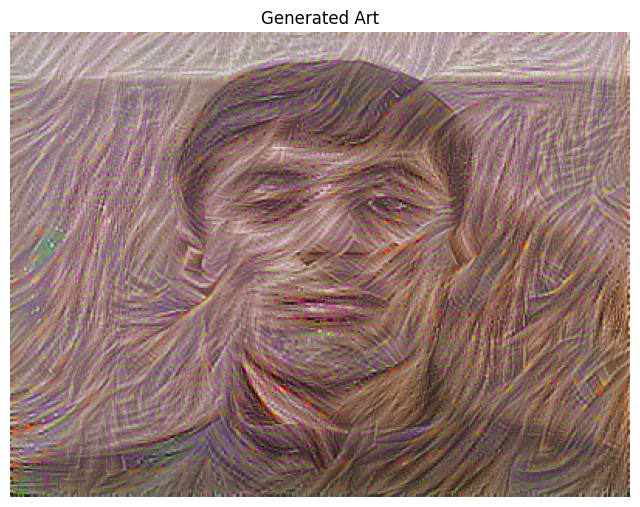

---

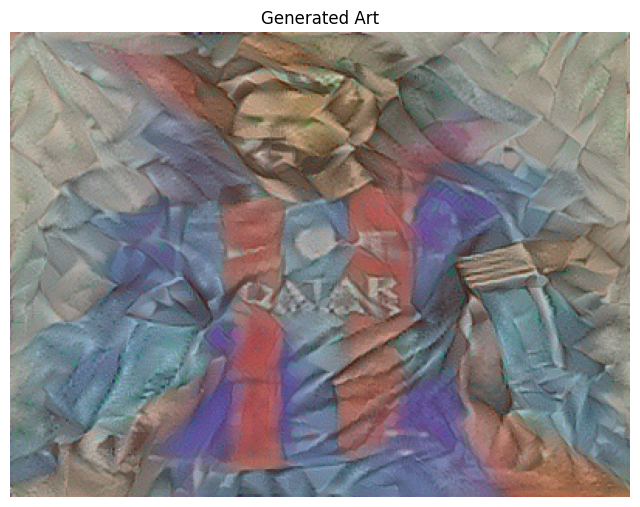

---

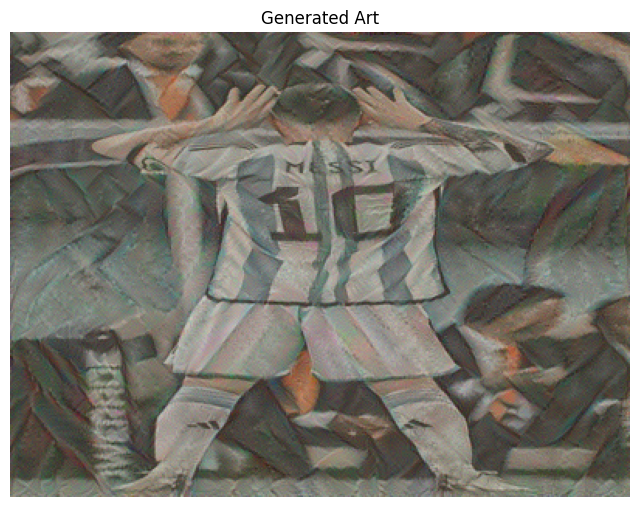

---

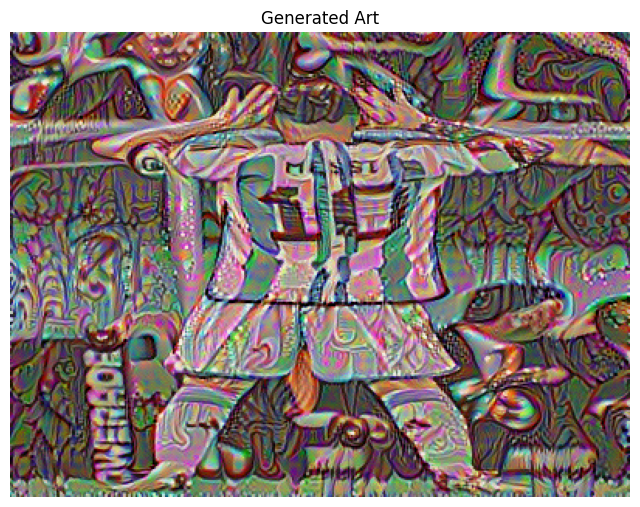
